In [ ]:
!pip install -U torch torchvision
!pip uninstall wheel -y
!pip install "wheel==0.34.2"

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.7.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.8.1+cu101)
Uninstalling wheel-0.35.1:
  Successfully uninstalled wheel-0.35.1


In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [ ]:
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
!pip uninstall -y torch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install torch==1.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
import torch

Uninstalling torch-1.7.0+cu101:
  Successfully uninstalled torch-1.7.0+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3MB 24kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/data/simpsons.zip -d my_data

In [ ]:
!ls my_data
train = "my_data/train"
test = "my_data/testset"

characters_illustration.png  sample_submission.csv  testset  train


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Dec  3 06:37:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'test' :
            transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),                                
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)
            return x
        elif self.mode=='val':
            transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
            x = self.load_sample(self.files[index])
            
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        elif self.mode == 'train' :
            transform = transforms.Compose([
              transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)) ,                             
              transforms.RandomResizedCrop(input_size),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('my_data/train/simpsons_dataset')
TEST_DIR = Path('my_data/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(test_files)

[PosixPath('my_data/testset/testset/img0.jpg'), PosixPath('my_data/testset/testset/img1.jpg'), PosixPath('my_data/testset/testset/img10.jpg'), PosixPath('my_data/testset/testset/img100.jpg'), PosixPath('my_data/testset/testset/img101.jpg'), PosixPath('my_data/testset/testset/img102.jpg'), PosixPath('my_data/testset/testset/img103.jpg'), PosixPath('my_data/testset/testset/img104.jpg'), PosixPath('my_data/testset/testset/img105.jpg'), PosixPath('my_data/testset/testset/img106.jpg'), PosixPath('my_data/testset/testset/img107.jpg'), PosixPath('my_data/testset/testset/img108.jpg'), PosixPath('my_data/testset/testset/img109.jpg'), PosixPath('my_data/testset/testset/img11.jpg'), PosixPath('my_data/testset/testset/img110.jpg'), PosixPath('my_data/testset/testset/img111.jpg'), PosixPath('my_data/testset/testset/img112.jpg'), PosixPath('my_data/testset/testset/img113.jpg'), PosixPath('my_data/testset/testset/img114.jpg'), PosixPath('my_data/testset/testset/img115.jpg'), PosixPath('my_data/testse

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')
# тут кончается часть из ноутбука про симпсонов , где происходит преобразование данных 

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 42

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#функция для тернировки взятая из документации pytorh


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    # if lr_sched is not None :
    #   lr_sched.step()
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(),weight_decay=0.01,amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        # scheduler = opt.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.5)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# def set_parameter_requires_grad(model, feature_extracting):
#     if feature_extracting:
#         for param in model.parameters():
#             param.requires_grad = False

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(DEVICE)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

lt=8
cntr=0

for child in model_ft.children():
 cntr+=1

 if cntr < lt:
    print (child)
    for param in child.parameters():
        param.requires_grad = False

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

TypeError: ignored

In [ ]:
criterion = nn.CrossEntropyLoss()


In [ ]:
history = train(train_dataset, val_dataset, model=model_ft, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.0590230469810287


epoch:  10%|█         | 1/10 [02:09<19:22, 129.15s/it]


Epoch 001 train_loss: 1.0590     val_loss 0.6140 train_acc 0.7277 val_acc 0.8357
loss 1.6940004991584465


epoch:  20%|██        | 2/10 [04:18<17:13, 129.15s/it]


Epoch 002 train_loss: 1.6940     val_loss 0.5616 train_acc 0.5352 val_acc 0.8538
loss 0.7622120486481857


epoch:  30%|███       | 3/10 [06:27<15:05, 129.29s/it]


Epoch 003 train_loss: 0.7622     val_loss 0.5352 train_acc 0.7976 val_acc 0.8565
loss 0.6355608393868197


epoch:  40%|████      | 4/10 [08:37<12:56, 129.35s/it]


Epoch 004 train_loss: 0.6356     val_loss 0.4068 train_acc 0.8321 val_acc 0.8930
loss 0.5800828935538244


epoch:  50%|█████     | 5/10 [10:46<10:47, 129.42s/it]


Epoch 005 train_loss: 0.5801     val_loss 0.3306 train_acc 0.8463 val_acc 0.9157
loss 0.5362128069753275


epoch:  60%|██████    | 6/10 [12:56<08:37, 129.44s/it]


Epoch 006 train_loss: 0.5362     val_loss 0.3827 train_acc 0.8553 val_acc 0.9049
loss 0.5146322960883647


epoch:  70%|███████   | 7/10 [15:05<06:28, 129.40s/it]


Epoch 007 train_loss: 0.5146     val_loss 0.3204 train_acc 0.8629 val_acc 0.9230
loss 0.4798370385460052


epoch:  80%|████████  | 8/10 [17:15<04:18, 129.48s/it]


Epoch 008 train_loss: 0.4798     val_loss 0.4101 train_acc 0.8711 val_acc 0.9006
loss 0.4584035582204967


epoch:  90%|█████████ | 9/10 [19:24<02:09, 129.45s/it]


Epoch 009 train_loss: 0.4584     val_loss 0.3119 train_acc 0.8778 val_acc 0.9217
loss 0.4354966288786404


epoch: 100%|██████████| 10/10 [21:34<00:00, 129.48s/it]


Epoch 010 train_loss: 0.4355     val_loss 0.3074 train_acc 0.8841 val_acc 0.9261


In [ ]:
model_weights = copy.deepcopy(model_ft.state_dict())
torch.save(model_weights, "path_to\\model_wights.pth") 

In [ ]:
model_ft.load_state_dict(torch.load('/content/path_to\model_wights.pth'))
model_ft.to(DEVICE)
model_ft.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
history = train(train_dataset, val_dataset, model=model_ft, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.477118859640982


epoch:  20%|██        | 1/5 [02:09<08:39, 129.83s/it]


Epoch 001 train_loss: 0.4771     val_loss 0.3669 train_acc 0.8726 val_acc 0.9062
loss 0.527365028360815


epoch:  40%|████      | 2/5 [04:19<06:28, 129.65s/it]


Epoch 002 train_loss: 0.5274     val_loss 0.4725 train_acc 0.8583 val_acc 0.8814
loss 0.44495509876539485


epoch:  60%|██████    | 3/5 [06:28<04:19, 129.57s/it]


Epoch 003 train_loss: 0.4450     val_loss 0.2948 train_acc 0.8811 val_acc 0.9245
loss 0.40051385616032104


epoch:  80%|████████  | 4/5 [08:38<02:09, 129.63s/it]


Epoch 004 train_loss: 0.4005     val_loss 0.3339 train_acc 0.8921 val_acc 0.9123
loss 0.3966238520784631


epoch: 100%|██████████| 5/5 [10:47<00:00, 129.52s/it]


Epoch 005 train_loss: 0.3966     val_loss 0.2705 train_acc 0.8935 val_acc 0.9327


In [ ]:
model_weights = copy.deepcopy(model_ft.state_dict())
torch.save(model_weights, "path_to\\model_wights2.pth") 

In [ ]:
model_ft.load_state_dict(torch.load('/content/path_to\model_wights2.pth'))
model_ft.to(DEVICE)
model_ft.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
history = train(train_dataset, val_dataset, model=model_ft, epochs=4, batch_size=64)

In [ ]:
model_weights = copy.deepcopy(model_ft.state_dict())
torch.save(model_weights, "path_to\\model_wights3.pth") 

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

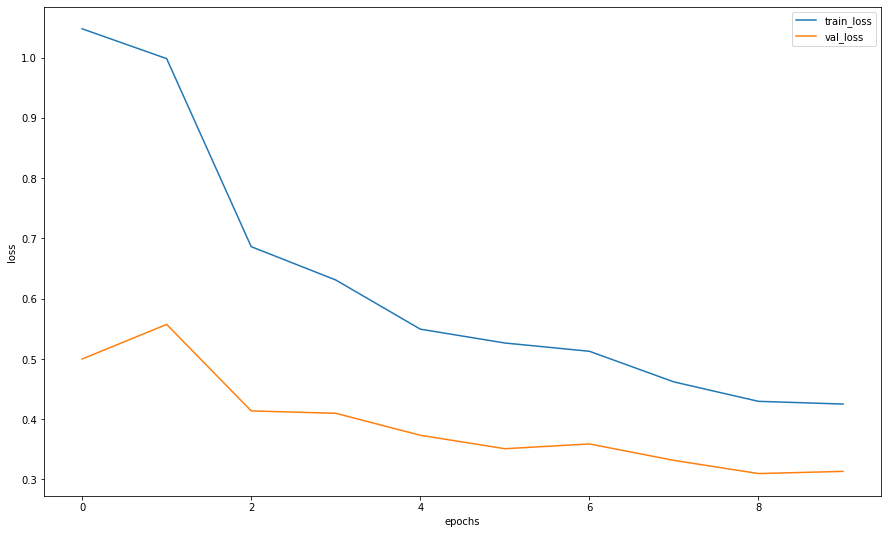

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_ft, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_ft, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
print(label_encoder)

LabelEncoder()


In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
print(y_pred , actual_labels)

[2 0 4 4 6 2 0 4 2 4 2 2 2 0 2 4 6 4 4 6] [2, 0, 4, 4, 6, 2, 0, 4, 2, 4, 2, 2, 2, 0, 2, 2, 6, 4, 4, 6]


In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred,average='weighted')

0.9502564102564103

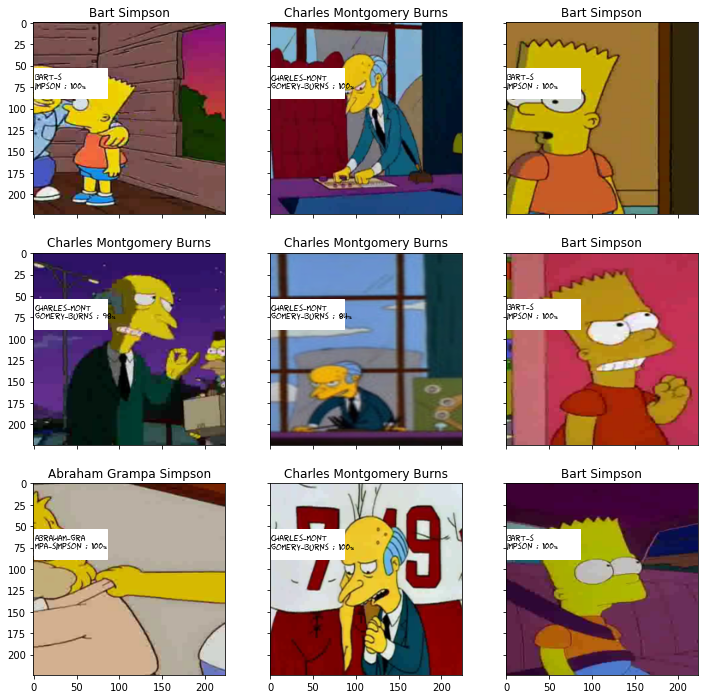

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
#My-submit for kaggle
test_dataset = (SimpsonsDataset(test_files, mode="test"))
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ft, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]
print(test_dataset)

In [ ]:
! ls

 drive	 label_encoder.pkl   my_data  'path_to\model_wights.pth'   sample_data


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/my_data/sample_submission.csv")
my_submit = pd.DataFrame({'Id':test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('./m_submission.csv')
my_submit_2=pd.read_csv('./m_submission.csv', index_col ='Id')
my_submit = my_submit_2
my_submit.drop(['Unnamed: 0'], axis='columns', inplace=True)
my_submit.to_csv('./new_submission.csv')
my_submit.head()
my_submit.sort_index(inplace=True)
my_submit.head()



# submission.to_csv('./m_submission.csv')
# my=pd.read_csv('./m_submission.csv',index_col='Id')
# my.to_csv('./1_submission.csv')
# submission = my
# submission.drop(['Unnamed: 0'], axis='columns', inplace=True)


# submission.to_csv('./my_submission.csv')


,Expected
Id,
img0.jpg,nelson_muntz
img1.jpg,bart_simpson
img10.jpg,ned_flanders
img100.jpg,chief_wiggum
img101.jpg,apu_nahasapeemapetilon
